# Collaboration and Competition

---

This notebook contains a solution for the Collaboration and Competition project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). This solution was prepared on local machine under Ubuntu-20.04. Instructions for environment setup are located in README.md file.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

In [2]:
from collections import deque
from unityagents import UnityEnvironment

import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import random

%matplotlib inline

Next, if not already done, fetch environment files and start it.

In [3]:
# fetch the Reacher Linux environment if not present
![[ ! -d "Tennis_Linux" ]] && wget https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip && unzip Tennis_Linux.zip

env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
import time

for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        time.sleep(0.1)
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### Prepare Utilities

In [6]:
import os
import torch
import torch.nn.functional as F
import torch.distributed as dist
from torch.autograd import Variable
import numpy as np

device = 'cpu'

def transpose_list(mylist):
    return list(map(list, zip(*mylist)))

def transpose_to_tensor(input_list):
    make_tensor = lambda x: torch.tensor(x, dtype=torch.float)
    return list(map(make_tensor, zip(*input_list)))


# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L11
def soft_update(target, source, tau):
    """
    Perform DDPG soft update (move target params toward source based on weight
    factor tau)
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
        tau (float, 0 < x < 1): Weight factor for update
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(target_param.data * (1.0 - tau) + param.data * tau)

# https://github.com/ikostrikov/pytorch-ddpg-naf/blob/master/ddpg.py#L15
def hard_update(target, source):
    """
    Copy network parameters from source to target
    Inputs:
        target (torch.nn.Module): Net to copy parameters to
        source (torch.nn.Module): Net whose parameters to copy
    """
    for target_param, param in zip(target.parameters(), source.parameters()):
        target_param.data.copy_(param.data)

# https://github.com/seba-1511/dist_tuto.pth/blob/gh-pages/train_dist.py
def average_gradients(model):
    """ Gradient averaging. """
    size = float(dist.get_world_size())
    for param in model.parameters():
        dist.all_reduce(param.grad.data, op=dist.reduce_op.SUM, group=0)
        param.grad.data /= size

# https://github.com/seba-1511/dist_tuto.pth/blob/gh-pages/train_dist.py
def init_processes(rank, size, fn, backend='gloo'):
    """ Initialize the distributed environment. """
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(backend, rank=rank, world_size=size)
    fn(rank, size)

def onehot_from_logits(logits, eps=0.0):
    """
    Given batch of logits, return one-hot sample using epsilon greedy strategy
    (based on given epsilon)
    """
    # get best (according to current policy) actions in one-hot form
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    if eps == 0.0:
        return argmax_acs
    # get random actions in one-hot form
    rand_acs = Variable(torch.eye(logits.shape[1])[[np.random.choice(
        range(logits.shape[1]), size=logits.shape[0])]], requires_grad=False)
    # chooses between best and random actions using epsilon greedy
    return torch.stack([argmax_acs[i] if r > eps else rand_acs[i] for i, r in
                        enumerate(torch.rand(logits.shape[0]))])

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """Sample from Gumbel(0, 1)"""
    U = Variable(tens_type(*shape).uniform_(), requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def gumbel_softmax_sample(logits, temperature):
    """ Draw a sample from the Gumbel-Softmax distribution"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data))
    return F.softmax(y / temperature, dim=1)

# modified for PyTorch from https://github.com/ericjang/gumbel-softmax/blob/master/Categorical%20VAE.ipynb
def gumbel_softmax(logits, temperature=0.5, hard=False):
    """Sample from the Gumbel-Softmax distribution and optionally discretize.
    Args:
      logits: [batch_size, n_class] unnormalized log-probs
      temperature: non-negative scalar
      hard: if True, take argmax, but differentiate w.r.t. soft sample y
    Returns:
      [batch_size, n_class] sample from the Gumbel-Softmax distribution.
      If hard=True, then the returned sample will be one-hot, otherwise it will
      be a probabilitiy distribution that sums to 1 across classes
    """
    y = gumbel_softmax_sample(logits, temperature)
    if hard:
        y_hard = onehot_from_logits(y)
        y = (y_hard - y).detach() + y
    return y

### OU Noise

In [7]:
import numpy as np
import random
import copy
import torch
    

# from https://github.com/songrotek/DDPG/blob/master/ou_noise.py
class OUNoise:

    def __init__(self, action_dimension, scale=1.0, mu=0, theta=0.15, sigma=0.2):
        self.action_dimension = action_dimension
        self.scale = scale
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.state = np.ones(self.action_dimension) * self.mu
        self.reset()

    def reset(self):
        self.state = np.ones(self.action_dimension) * self.mu

    def noise(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(len(x))
        self.state = x + dx
        return torch.tensor(self.state * self.scale).float()

### Model

In [8]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

device = "cpu"

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""       
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=400, fc2_units=300):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.relu(self.fc1(state))
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay buffer

In [9]:
from collections import deque
import random


class ReplayBuffer:
    def __init__(self,size):
        self.size = size
        self.deque = deque(maxlen=self.size)

    def push(self,transition):
        """push into the buffer"""
        self.deque.append(transition)

    def sample(self, batchsize):
        """sample from the buffer"""
        samples = random.sample(self.deque, batchsize)

        # transpose list of list
        return transpose_list(samples)

    def __len__(self):
        return len(self.deque)

### MADDPG agent

In [16]:
import numpy as np
import random
import torch
import torch.nn.functional as F
import torch.optim as optim

LR_ACTOR = 5e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic

device = "cpu"

class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, num_agents):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR, weight_decay=0)

        # Critic Network / Target Network)
        self.critic = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_target = Critic(state_size*num_agents, action_size*num_agents, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC, weight_decay=0)

        # Noise process
        self.noise = OUNoise(action_size, scale=1.0, sigma=0.4)
    
    def act(self, obs, noise=0.0):
        obs = obs.to(device)
        action = self.actor(obs) + noise*self.noise.noise()
        return torch.clamp(action,-1,1)
    
    def target_act(self, obs):
        obs = obs.to(device)
        return self.actor_target(obs)
    
    def reset(self):
        self.noise.reset()
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

### MADDPG agent

In [15]:
ddevice = 'cpu'


UPDATE_EVERY = 20
UPDATE_STEPS = 15
BATCH_SIZE = 256
BUFFER_SIZE = int(1e6)  # replay buffer size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters

class MADDPG:
    def __init__(self, state_size, action_size, random_seed, num_agents):
        self.maddpg_agent = [DDPGAgent(state_size, action_size, random_seed, num_agents) for _ in range(num_agents)]
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size

        self.buffer = ReplayBuffer(BUFFER_SIZE)
        self.iter = 0

    def step(self, transition, skip_training=False):
        self.buffer.push(transition)

        self.iter += 1
        if not skip_training and \
            len(self.buffer) >= BATCH_SIZE and \
            (self.iter % UPDATE_EVERY) == 0:
            self.learn()

    def learn(self):
        for _ in range(UPDATE_STEPS):
            for agent_num in range(num_agents):
                samples = self.buffer.sample(BATCH_SIZE)
                self.update(samples, agent_num)

    def get_actors(self):
        """get actors of all the agents in the MADDPG object"""
        actors = [agent.actor for agent in self.maddpg_agent]
        return actors

    def get_target_actors(self):
        """get target_actors of all the agents in the MADDPG object"""
        target_actors = [agent.actor_target for agent in self.maddpg_agent]
        return target_actors

    def act(self, obs_all_agents, noise=0.0):
        """get actions from all agents in the MADDPG object"""
        actions = [agent.act(obs, noise) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return actions

    def target_act(self, obs_all_agents, noise=0.0):
        """get target network actions from all the agents in the MADDPG object """
        target_actions = [agent.target_act(obs) for agent, obs in zip(self.maddpg_agent, obs_all_agents)]
        return target_actions

    def reset(self):
        for a in self.maddpg_agent:
            a.reset()

    def update(self, samples, agent_number):
        """update the critics and actors of all the agents """
        obs, action, reward, next_obs, done = map(transpose_to_tensor, samples) # get data

        # full versions of obs and actions are needed for the critics
        obs_full = torch.cat(obs, 1)
        next_obs_full = torch.cat(next_obs, 1)
        action_full = torch.cat(action, 1)

        agent = self.maddpg_agent[agent_number]
        agent.critic_optimizer.zero_grad()

        #critic loss = batch mean of (y- Q(s,a) from target network)^2
        #y = reward of this timestep + discount * Q(st+1,at+1) from target network
        target_actions = self.target_act(next_obs)
        target_actions = torch.cat(target_actions, dim=1)

        q_next = agent.critic_target(next_obs_full, target_actions).detach()

        y = reward[agent_number].unsqueeze(-1) + (GAMMA * q_next * (1 - done[agent_number].unsqueeze(-1)))
        q = agent.critic(obs_full, action_full)

        loss = torch.nn.MSELoss()
        critic_loss = loss(q, y.detach())
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 1.0)
        agent.critic_optimizer.step()

        #update actor network using policy gradient
        agent.actor_optimizer.zero_grad()

        q_input = [agent.actor(ob) for ob, agent in zip(obs, self.maddpg_agent)]
        q_input = [a.detach() if idx != agent_number else a for idx, a in enumerate(q_input)]
        q_input = torch.cat(q_input, dim=1)

        # get the policy gradient
        actor_loss = -agent.critic(obs_full, q_input).mean()
        actor_loss.backward()
        agent.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        agent.soft_update(agent.critic, agent.critic_target, TAU)
        agent.soft_update(agent.actor, agent.actor_target, TAU)

    def save(self):
        for idx, agent in enumerate(self.maddpg_agent):
            torch.save(agent.actor.state_dict(), f"actor_{idx}_local.pth")
            torch.save(agent.actor_target.state_dict(), f"actor_{idx}_target.pth")
            torch.save(agent.critic.state_dict(), f"critic_{idx}_local.pth")
            torch.save(agent.critic_target.state_dict(), f"critic_{idx}_target.pth")

    def load(self):
        for idx, agent in enumerate(self.maddpg_agent):
            agent.actor.load_state_dict(torch.load(f"actor_{idx}_local.pth"))
            agent.actor_target.load_state_dict(torch.load(f"actor_{idx}_target.pth"))
            agent.critic.load_state_dict(torch.load(f"critic_{idx}_local.pth"))
            agent.critic_target.load_state_dict(torch.load(f"critic_{idx}_target.pth"))

### Train the agent

In [12]:
from collections import deque

MONTE_CARLO_EPISODES=10

def maddpg(agent, n_episodes=5000, solved_score=0.5):
    max_scores_window = deque(maxlen=100)
    max_scores_all = []
    average_score = 0

    noise = 1.0
    noise_min = 0.1
    noise_reduction = 0.9995

    step = 0

    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]     # reset the environment
        agent.reset()
        obs = env_info.vector_observations                 # get the current state (2,24)
        states = [agent_state for agent_state in obs]    # make a list
        score = np.zeros(num_agents)

        only_sampling = (i_episode <= MONTE_CARLO_EPISODES)

        while True:
            if only_sampling:
                actions_array = np.random.uniform(-1, 1, 4).reshape(num_agents, action_size)
            else:
                actions = agent.act(transpose_to_tensor([states]), noise=noise)        # each agent choose the actions
                actions_array = torch.stack(actions).detach().numpy().squeeze()                 # numpy array from ations

            env_info = env.step(actions_array)[brain_name]              # The environment accepts full actions

            next_obs = env_info.vector_observations                     # get next observations
            next_states = [agent_state for agent_state in next_obs]     # reshape them into a list

            rewards = np.array(env_info.rewards)
            dones = np.array(env_info.local_done)

            transition = ((states, actions_array, rewards, next_states, dones))
            agent.step(transition, skip_training=only_sampling)

            score += rewards
            states = next_states # after each timestep update the obs to the new obs before restarting the loop

            if np.any(dones):                                  # exit loop if episode finished
                break

        max_scores = np.max(score)
        max_scores_window.append(max_scores)
        max_scores_all.append(max_scores)
        average_score = np.mean(max_scores_window)

        if only_sampling:
            continue

        noise = max(noise * noise_reduction, noise_min)

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}\tSteps: {}\tNoise scale: {:.4f}'.format(i_episode, average_score, step, noise))

        if average_score >= solved_score:
            agent.save()
            print('\rEnvironment solved Episode {}\tAverage Score: {:.4f}'.format(i_episode, average_score))
            break

    return max_scores_all


agent = MADDPG(state_size, action_size, random_seed = 33, num_agents=num_agents)
scores = maddpg(agent)


Save expreriences from random play	....Done
Episode 100	Average Score: 0.0010	Steps: 1206	Noise scale: 0.9920
Episode 200	Average Score: 0.0009	Steps: 2547	Noise scale: 0.9436
Episode 300	Average Score: 0.0029	Steps: 3927	Noise scale: 0.8976
Episode 400	Average Score: 0.0058	Steps: 5377	Noise scale: 0.8538
Episode 500	Average Score: 0.0135	Steps: 6953	Noise scale: 0.8122
Episode 600	Average Score: 0.0202	Steps: 8804	Noise scale: 0.7725
Episode 700	Average Score: 0.0078	Steps: 10302	Noise scale: 0.7349
Episode 800	Average Score: 0.0079	Steps: 11807	Noise scale: 0.6990
Episode 900	Average Score: 0.0106	Steps: 13371	Noise scale: 0.6649
Episode 1000	Average Score: 0.0188	Steps: 15231	Noise scale: 0.6325
Episode 1100	Average Score: 0.0216	Steps: 17160	Noise scale: 0.6016
Episode 1200	Average Score: 0.0293	Steps: 19106	Noise scale: 0.5723
Episode 1300	Average Score: 0.0462	Steps: 21583	Noise scale: 0.5444
Episode 1400	Average Score: 0.0745	Steps: 24781	Noise scale: 0.5178
Episode 1500	Averag

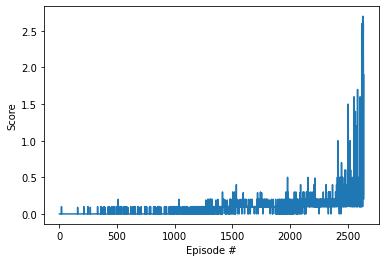

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()